In [1]:
from utils import *

import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
%matplotlib inline

import plotly
from plotly import graph_objs
plotly.offline.init_notebook_mode()
from plotly.offline import iplot

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.style import set_palette
set_palette('yellowbrick')
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
from textblob import Word

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report,balanced_accuracy_score, precision_recall_curve
from sklearn.metrics import confusion_matrix

import seaborn as sn


### Import Dataset

In [2]:
df = pd.read_csv('labeled_data.csv')
df.head(10)

Unnamed: 0  count  hate_speech  offensive_language  neither  class   
0           0      3            0                   0        3      2  \
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   
5           5      3            1                   2        0      1   
6           6      3            0                   3        0      1   
7           7      3            0                   3        0      1   
8           8      3            0                   3        0      1   
9           9      3            1                   2        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
5  !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...  
6  !!!!!!"@__BrighterDays: I can not just sit up ...  
7  !!!!&#8220;@selfiequeenbri: cause I'm tired of...  
8  " &amp; you might not get ya bitch back &amp; ...  
9  " @rhythmixx_ :hobbies include: fighting Maria...

In [3]:
df['class'].value_counts()

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

In [4]:
hate = len(df[df['class']==0])
neutral = len(df[df['class']==2])
offensive = len(df[df['class']==1])
print(f'hate : {hate} , neutral : {neutral}, offensive : {offensive}')

dist = [graph_objs.Bar(
    x=['hate','offensive','neutral'],
    y=[hate, offensive, neutral],
)]
plotly.offline.iplot({'data': dist, 'layout': graph_objs.Layout(title='Class Distribution Visualisation')})

hate : 1430 , neutral : 4163, offensive : 19190


### Data Preprocessing

In [5]:
"""
    Remove Unnamed column from dataframe, 
    Keep only two classes hate_speech with class label 1 and combine offensive and neutral with class label 0
"""
df = df.drop('Unnamed: 0', axis = 1)
df['class'] = df['class'].replace(2,1)
df['class'] = df['class'].replace([0,1],[1,0])

In [6]:
df.head()

count  hate_speech  offensive_language  neither  class   
0      3            0                   0        3      0  \
1      3            0                   3        0      0   
2      3            0                   3        0      0   
3      3            0                   2        1      0   
4      6            0                   6        0      0   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [7]:
df['class'].value_counts()

class
0    23353
1     1430
Name: count, dtype: int64

In [8]:
preprocess_tweet(df, 'tweet')

In [9]:
df.head()

count  hate_speech  offensive_language  neither  class   
0      3            0                   0        3      0  \
1      3            0                   3        0      0   
2      3            0                   3        0      0   
3      3            0                   2        1      0   
4      6            0                   6        0      0   

                                               tweet  
0  as a woman you shouldnt complain about cleanin...  
1  boy dats coldtyga dwn bad for cuffin dat hoe i...  
2  dawg you ever fuck a bitch and she start to cr...  
3                             she look like a tranny  
4  the shit you hear about me might be true or it...

In [10]:
df1 = df.drop(columns =['count', 'hate_speech', 'offensive_language', 'neither'])
df1.head()

class                                              tweet
0      0  as a woman you shouldnt complain about cleanin...
1      0  boy dats coldtyga dwn bad for cuffin dat hoe i...
2      0  dawg you ever fuck a bitch and she start to cr...
3      0                             she look like a tranny
4      0  the shit you hear about me might be true or it...

In [11]:
df1= df1.iloc[:,[1,0]]

In [12]:
df1.head()

tweet  class
0  as a woman you shouldnt complain about cleanin...      0
1  boy dats coldtyga dwn bad for cuffin dat hoe i...      0
2  dawg you ever fuck a bitch and she start to cr...      0
3                             she look like a tranny      0
4  the shit you hear about me might be true or it...      0

### Splitting testing and training set

In [13]:
#for ease of use, changing column name from class to target
df1 = df1.rename(columns={'class': 'target'})
X = df1.tweet
y = df1.target

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
train = pd.concat([X_tr, y_tr], axis=1).reset_index()
train = train.drop(columns=['index'], axis=1)
train.head()

tweet  target
0  well how else will white ppl get us to forget ...       1
1  funny thing isits not just the people doing it...       0
2                  nigga messed with the wrong bitch       0
3                                 bitch ass nigggaaa       0
4                                 so that real bitch       0

In [15]:
val = pd.concat([X_val, y_val], axis=1).reset_index()
val = val.drop(columns=['index'], axis=1)

## Visualizations 

In [16]:
zero = train[train.target == 0]
one = train[train.target == 1]

zero_tokens = tokenize(zero, 'tweet')
one_tokens = tokenize(one, 'tweet')
zero_tokenz = no_stopwords(zero_tokens)
one_tokenz = no_stopwords(one_tokens)

/Users/manveerkaur/Documents/SentimentAnalysis/utils.py:134: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



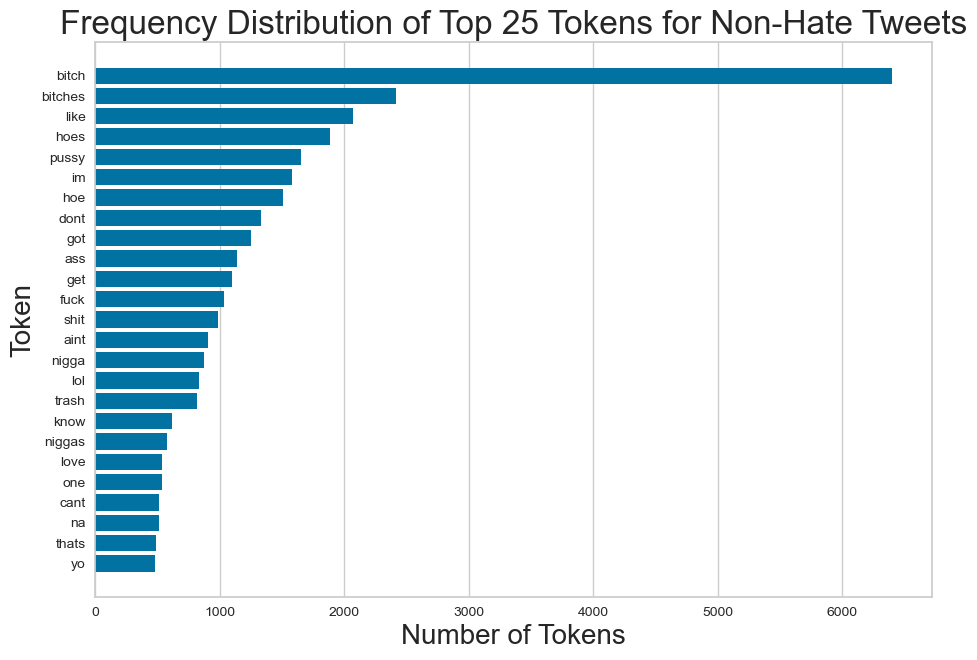

In [17]:
plot_frequency_dist(zero_tokenz, 'Non-Hate')

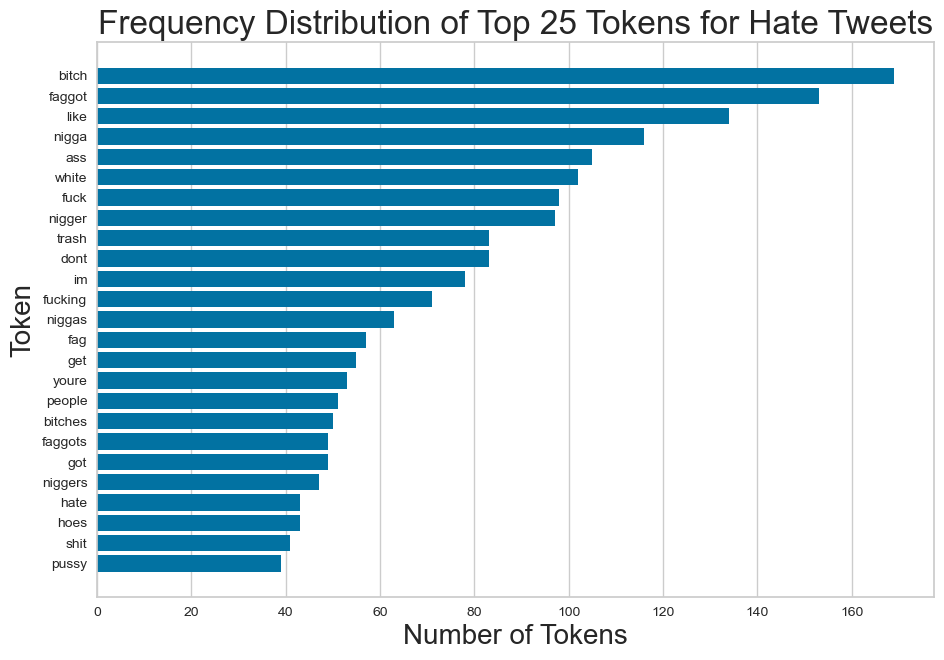

In [18]:
plot_frequency_dist(one_tokenz, 'Hate')

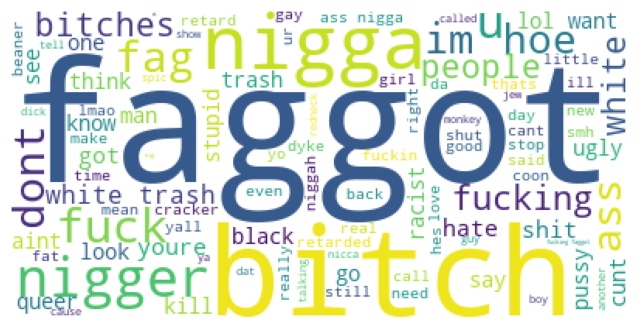

In [19]:
## Generate and plot wordcloud of hate tweets
plot_wordCloud(one_tokenz)

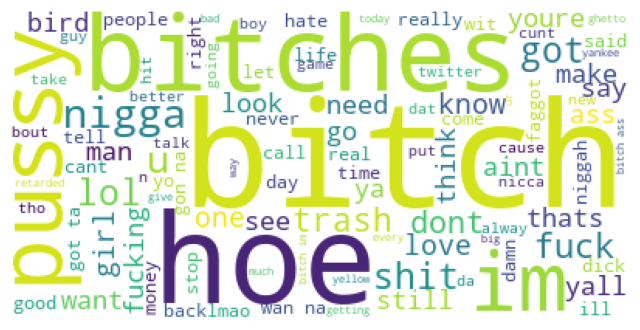

In [20]:
## Generate and plot wordcloud of not-hate tweets
plot_wordCloud(zero_tokenz)

### Vocabulary Unique to hate speech

In [21]:
hate_list = np.setdiff1d(one_tokenz, zero_tokenz)
hate_list

array(['aa', 'absolved', 'accord', 'acknowledged', 'activity', 'aflcio',
       'aged', 'agg', 'ahhhahahaha', 'ahmed', 'airlines', 'aklve',
       'alaqsa', 'alcoholics', 'alls', 'alsarabsss', 'amazement',
       'americathey', 'amigo', 'anglo', 'anon', 'antiracist',
       'antisemite', 'antizionist', 'apartheid', 'appearance',
       'argentino', 'ariza', 'arkansas', 'aryan', 'aslina', 'attorney',
       'axin', 'azflooding', 'azmonsoon', 'backpedals', 'baiters', 'baka',
       'balless', 'ballless', 'banner', 'banwagoning', 'barge',
       'barnyard', 'bateman', 'batshit', 'bazinga', 'bdubs', 'beamthat',
       'beiber', 'believes', 'belton', 'benghazzi', 'benton', 'bernstine',
       'beta', 'bias', 'bibles', 'bidens', 'bikes', 'birthdayyyy',
       'bisexual', 'bitcheslook', 'blacklisted', 'blaspheme',
       'blondeproblems', 'boris', 'boyraping', 'brainwash', 'brainwashed',
       'bran', 'brits', 'bromance', 'broner', 'buckcity', 'buffets',
       'buku', 'bulldozed', 'bundle',

In [22]:
len(hate_list)

627

In [23]:
hate_tokenz = [x for x in one_tokenz if x in hate_list]
len(hate_tokenz)

674

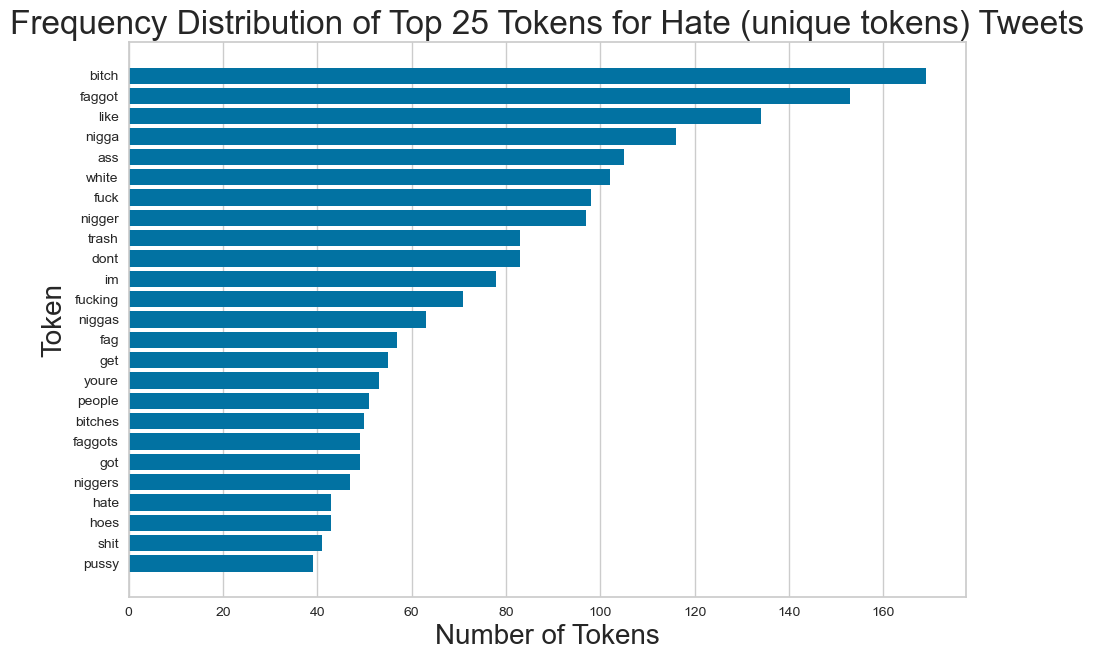

In [24]:
plot_frequency_dist(one_tokenz, "Hate (unique tokens)")

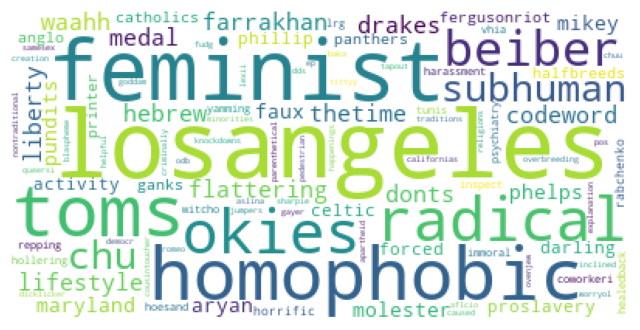

In [25]:
plot_wordCloud(hate_tokenz)

### Stopword Removal, Tokenization, Stemming, and Lemmatization 

In [26]:
train.tweet = train.tweet.apply(lambda x: re.sub(r'\b\w{1,2}\b', '', str(x)))
val.tweet = val.tweet.apply(lambda x: re.sub(r'\b\w{1,2}\b', '', str(x)))

train_tokens = tokenize(train, 'tweet')
val_tokens = tokenize(val, 'tweet')
train_tokenz = no_stopwords(train_tokens)
val_tokenz = no_stopwords(val_tokens)

In [27]:
stop_words = set(stopwords.words('english'))
stop_list = [''.join(c for c in s if c not in string.punctuation) for s in stop_words]

In [28]:
train_stem = stemming(train_tokenz)
val_stem = stemming(val_tokenz)


In [29]:
lemmatization(train)
lemmatization(val)
train.lem = train['lem'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_list]))
val.lem = val['lem'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_list]))

In [30]:
train.head()

tweet  target   
0  well how else will white ppl get   forget our ...       1  \
1  funny thing isits not just the people doing  i...       0   
2                  nigga messed with the wrong bitch       0   
3                                 bitch ass nigggaaa       0   
4                                    that real bitch       0   

                                                 lem  
0  well else white ppl get forget horrific past p...  
1  funny thing isits people people seeing pic jud...  
2                           nigga messed wrong bitch  
3                                     bitch nigggaaa  
4                                         real bitch

### Separating tweet and target for model

In [31]:
X_tr = train.lem
X_val = val.lem
y_tr = train.target
y_val = val.target

### TF-IDF Vectorizer

In [32]:
vec = TfidfVectorizer()
tfidf_tr = vec.fit_transform(X_tr)
tfidf_val = vec.transform(X_val)

### Multinomial Naive-Bayes

In [33]:
nb = MultinomialNB().fit(tfidf_tr, y_tr)
y_pr_nb_tr = nb.predict(tfidf_tr)
y_pr_nb_val = nb.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_nb_tr, y_pr_nb_val, nb)


Training F1 Score:  0.012195121951219513
Testing F1 Score:  0.0
Training Recall Score:  0.0061403508771929825
Testing Recall Score:  0.0
Training Precision Score:  0.875
Testing Precision Score:  0.0
Training Accuracy Score:  0.9428023807121961
Testing Accuracy Score:  0.9414968731087351


/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



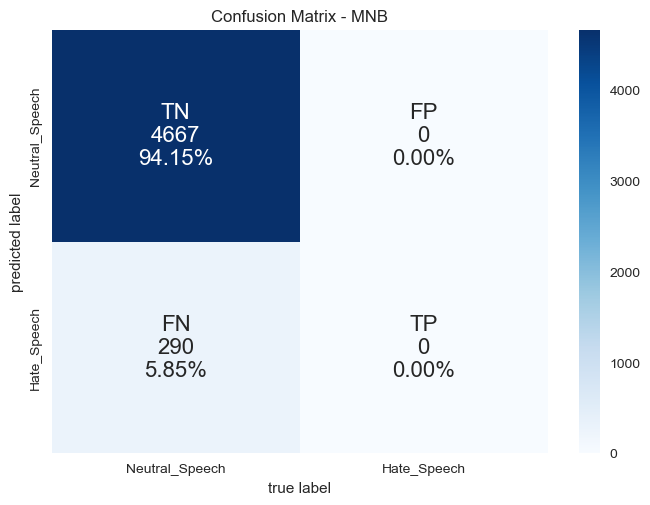

In [34]:
make_confusion_matrix(y_val, y_pr_nb_val, 'MNB')

### Random forest classifier

In [35]:
rf = RandomForestClassifier(n_estimators=100).fit(tfidf_tr, y_tr)
y_pr_rf_tr = rf.predict(tfidf_tr)
y_pr_rf_val = rf.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_rf_tr, y_pr_rf_val, rf)


Training F1 Score:  0.9829321663019693
Testing F1 Score:  0.17563739376770537
Training Recall Score:  0.9850877192982456
Testing Recall Score:  0.10689655172413794
Training Precision Score:  0.9807860262008734
Testing Precision Score:  0.49206349206349204
Training Accuracy Score:  0.9980328861091496
Testing Accuracy Score:  0.9412951381884204


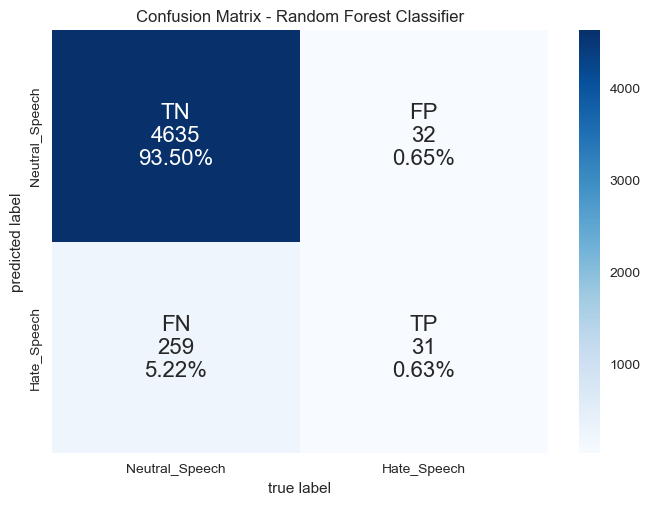

In [36]:
make_confusion_matrix(y_val, y_pr_rf_val, 'Random Forest Classifier')

### Logistic Regression 

In [37]:
log = LogisticRegression().fit(tfidf_tr, y_tr)
y_pr_log_tr = log.predict(tfidf_tr)
y_pr_log_val = log.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_log_tr, y_pr_log_val, log)

Training F1 Score:  0.25584795321637427
Testing F1 Score:  0.18487394957983194
Training Recall Score:  0.15350877192982457
Testing Recall Score:  0.11379310344827587
Training Precision Score:  0.7675438596491229
Testing Precision Score:  0.4925373134328358
Training Accuracy Score:  0.9486532835670332
Testing Accuracy Score:  0.9412951381884204


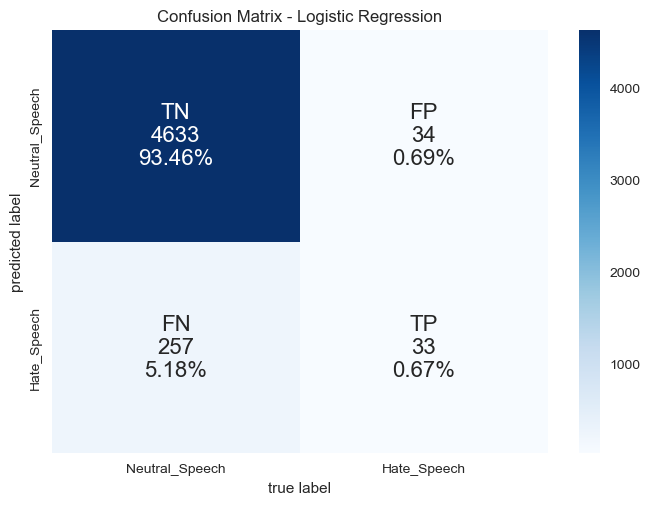

In [38]:
make_confusion_matrix(y_val, y_pr_log_val, 'Logistic Regression')

### Balancing Dataset

In [39]:
df = pd.read_csv('balanced_data_combined.csv')
df.head(10)

Unnamed: 0                                               text  class
0           0  Drasko they didn't cook half a bird you idiot ...      1
1           1  Hopefully someone cooks Drasko in the next ep ...      1
2           2  of course you were born in serbia...you're as ...      1
3           3  These girls are the equivalent of the irritati...      1
4           4  RT @YesYoureRacist: At least you're only a tin...      1
5           5  @MisfitInChains @oldgfatherclock @venereverita...      1
6           6  RT @Dreamdefenders: Eric Holder from #ferguson...      1
7           7  RT @AntonioFrench: I spent the morning at the ...      1
8           8  RT @harikondabolu: In his #Ferguson testimony,...      1
9           9  "He can't be a server at our restaurant, that ...      1

In [40]:
df = df.drop(columns = 'Unnamed: 0')

In [41]:
df.shape

(8337, 2)

In [42]:
df['class'].value_counts()

class
1    4174
0    4163
Name: count, dtype: int64

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8337 entries, 0 to 8336
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8335 non-null   object
 1   class   8337 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 130.4+ KB


In [44]:
hate = len(df[df['class']==1])
not_hate = len(df[df['class']==0])

print(f'hate : {hate} , not_hate : {not_hate}')

dist = [graph_objs.Bar(
    x=['hate','not_hate'],
    y=[hate, not_hate],
)]
plotly.offline.iplot({'data': dist, 'layout': graph_objs.Layout(title='Class Distribution Visualisation')})

hate : 4174 , not_hate : 4163


### Data Preprocessing

In [45]:
df.dropna(subset=['text'], inplace=True)

In [46]:
df = df.rename(columns={'text': 'tweet'})
preprocess_tweet(df, 'tweet')

### Splitting testing and training set

In [47]:
#for ease of use, changing column name from class to target
df1 = df.rename(columns={'class': 'target'})
X = df1.tweet
y = df1.target

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
train = pd.concat([X_tr, y_tr], axis=1).reset_index()
train = train.drop(columns=['index'], axis=1)
train.head()

tweet  target
0  im not sexist but when i see a lady driving a ...       1
1  ur a faggot if you change your name to your bd...       1
2      the early bearded man gets the clam herkfacts       0
3    i need a meme of thatthats my day in a nutshell       1
4         even nature looks awesome when colored in        0

In [49]:
train_xx = pd.concat([X_tr, y_tr], axis=1).reset_index()
train_xx = train_xx.drop(columns=['index'], axis=1)
train_xx.head()

tweet  target
0  im not sexist but when i see a lady driving a ...       1
1  ur a faggot if you change your name to your bd...       1
2      the early bearded man gets the clam herkfacts       0
3    i need a meme of thatthats my day in a nutshell       1
4         even nature looks awesome when colored in        0

In [50]:
train['tweet']

0       im not sexist but when i see a lady driving a ...
1       ur a faggot if you change your name to your bd...
2           the early bearded man gets the clam herkfacts
3         i need a meme of thatthats my day in a nutshell
4              even nature looks awesome when colored in 
                              ...                        
6663    looking back i liked colored better lets go ba...
6664    happy birthday to my pops old negro spiritual ...
6665    i missing something of my ofay friends day all...
6666    sweden man the swedish men are cattle at this ...
6667    at this point every voter in florida has voted...
Name: tweet, Length: 6668, dtype: object

In [51]:
val = pd.concat([X_val, y_val], axis=1).reset_index()
val = val.drop(columns=['index'], axis=1)

### Stopword Removal, Tokenization, Stemming, and Lemmatization 

In [52]:
stop_words = set(stopwords.words('english'))
stop_list = [''.join(c for c in s if c not in string.punctuation) for s in stop_words]

In [53]:
train.tweet = train.tweet.apply(lambda x: re.sub(r'\b\w{1,2}\b', '', str(x)))
val.tweet = val.tweet.apply(lambda x: re.sub(r'\b\w{1,2}\b', '', str(x)))

train_tokens = tokenize(train, 'tweet')
val_tokens = tokenize(val, 'tweet')
train_tokenz = no_stopwords(train_tokens)
val_tokenz = no_stopwords(val_tokens)

In [54]:
train_stem = stemming(train_tokenz)
val_stem = stemming(val_tokenz)

In [55]:
lemmatization(train)
lemmatization(val)
train.lem = train['lem'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_list]))
val.lem = val['lem'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_list]))

In [56]:
train.head()

tweet  target   
0   not sexist but when  see  lady driving  fast ...       1  \
1    faggot  you change your name  your bday just...       1   
2      the early bearded man gets the clam herkfacts       0   
3              need  meme  thatthats  day   nutshell       1   
4           even nature looks awesome when colored         0   

                                                 lem  
0  sexist see lady driving fast car get pissed ch...  
1  faggot change name bday get bday tweet aint ni...  
2               early bearded man get clam herkfacts  
3                   need meme thatthats day nutshell  
4                   even nature look awesome colored

### Visualizations

In [57]:
zero = train[train.target == 0]
one = train[train.target == 1]

zero_tokens = tokenize(zero, 'tweet')
one_tokens = tokenize(one, 'tweet')
zero_tokenz = no_stopwords(zero_tokens)
one_tokenz = no_stopwords(one_tokens)

/Users/manveerkaur/Documents/SentimentAnalysis/utils.py:134: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



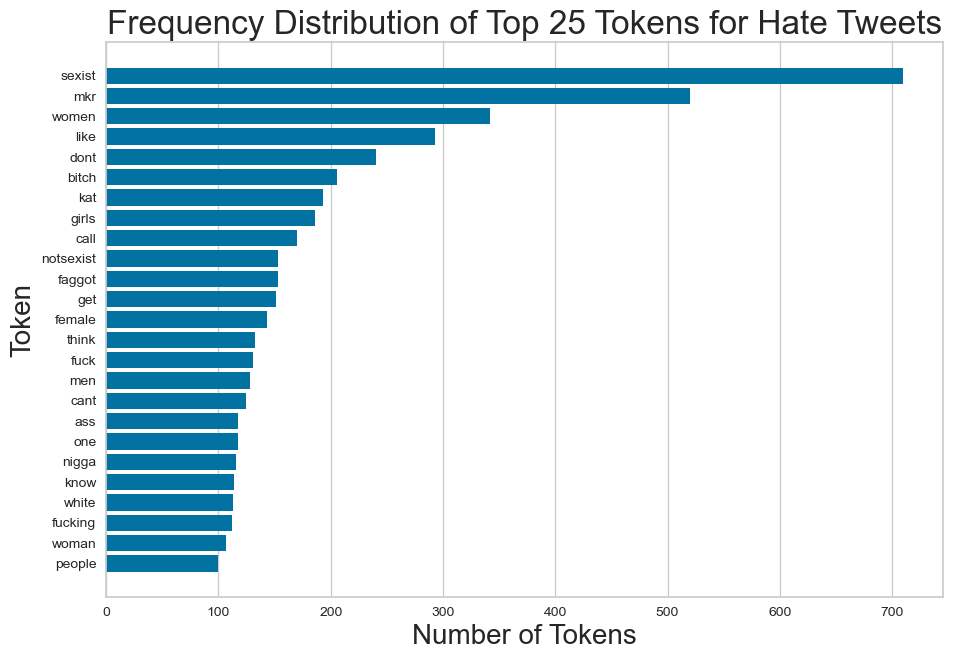

In [58]:
plot_frequency_dist(one_tokenz, 'Hate')

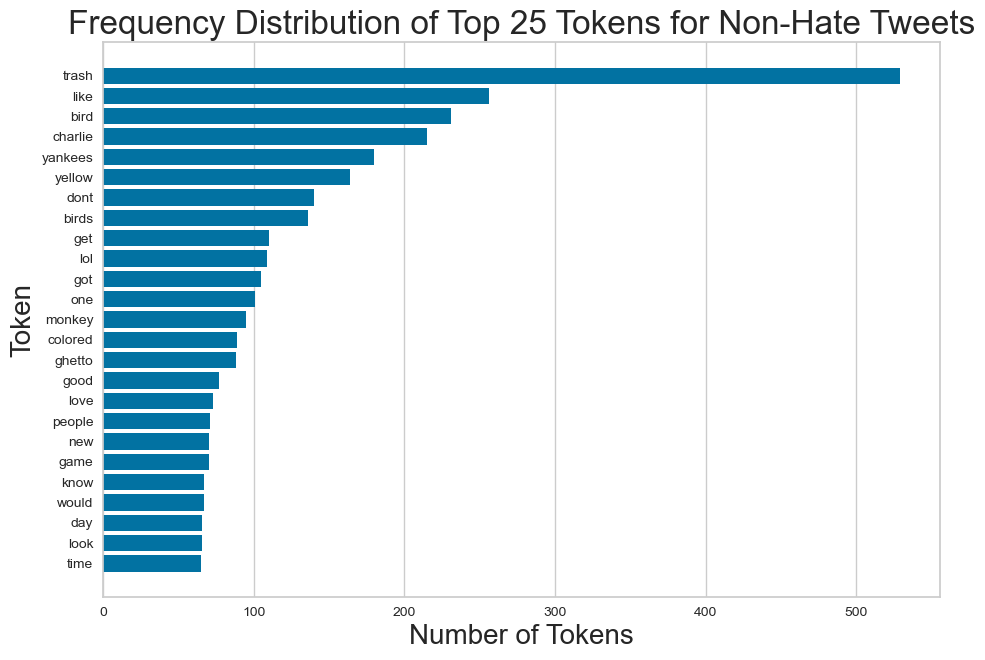

In [59]:
plot_frequency_dist(zero_tokenz, 'Non-Hate')

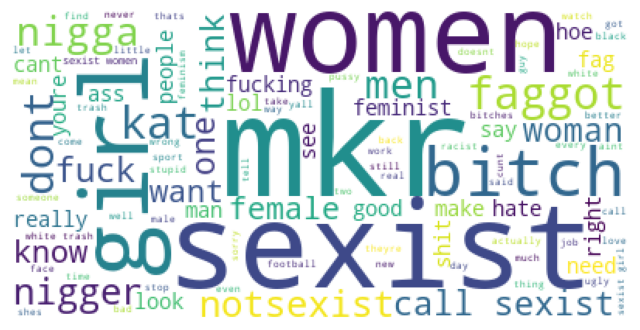

In [60]:
#word cloud of hate tokens
plot_wordCloud(one_tokenz)

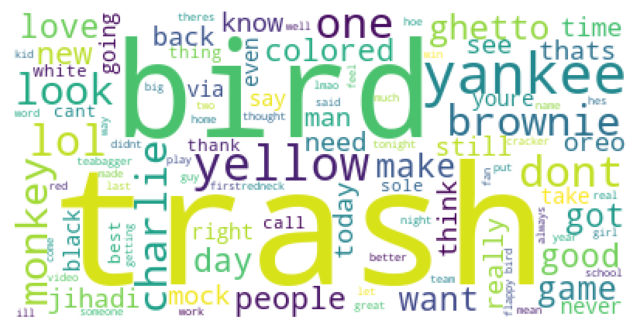

In [61]:
#word cloud of non-hate tokens
plot_wordCloud(zero_tokenz)

In [62]:
hate_list = np.setdiff1d(one_tokenz, zero_tokenz)
hate_list

array(['aaaaaaaaand', 'aaand', 'aaronmacgruder', ..., 'zoes', 'zooming',
       'zzzzzz'], dtype='<U29')

In [63]:
print(f'No. of hate tokens: {len(one_tokenz)}')
print(f'No. of non-hate tokens: {len(zero_tokenz)}')
print(f'No. of tokens unique to hate class : {len(hate_list)}')

No. of hate tokens: 26101
No. of non-hate tokens: 26012
No. of tokens unique to hate class : 3538


In [75]:
hate_tokenz = [x for x in one_tokenz if x in hate_list]
hate_tokenz = [x for x in hate_tokenz if x!='mkr']
hate_tokenz = [x for x in hate_tokenz if x!='kat']
hate_tokenz = [x for x in hate_tokenz if x!='andre']
hate_tokenz = [x for x in hate_tokenz if x!='katie']
hate_tokenz = [x for x in hate_tokenz if x!='nikki']

In [76]:
print(f"Total no. of unique hate tokens: {len(hate_list)}")
print(f"Count of occurence of unique hate tokens in tweets: {len(hate_tokenz)}")

Total no. of unique hate tokens: 3538
Count of occurence of unique hate tokens in tweets: 6981


In [77]:
print(f'No. of hate tokens {len(set(one_tokenz))}')

No. of hate tokens 6378


In [78]:
print(f'No. of unique non-hate tokens {len(set(zero_tokenz))}')

No. of unique non-hate tokens 8290


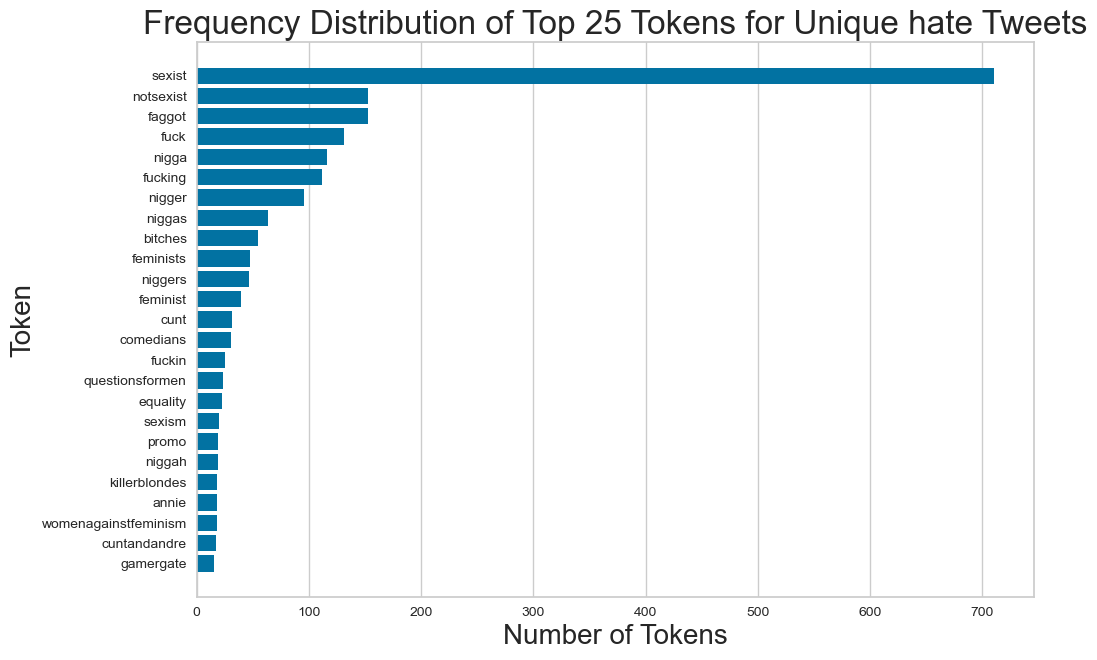

In [79]:
plot_frequency_dist(hate_tokenz, 'Unique hate')

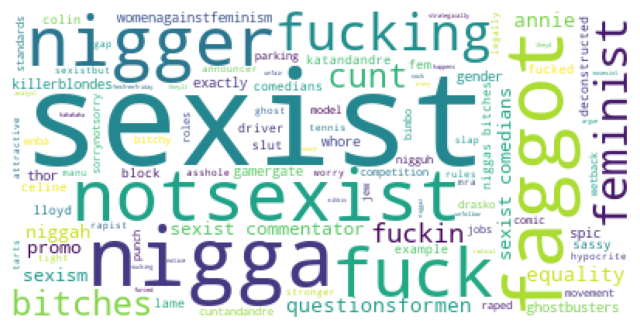

In [80]:
# word cloud depicting occurence of unique hate tokens
plot_wordCloud(hate_tokenz)

In [81]:
#Stemming and lemmatization visualization
train_stem[:25]

['sexist',
 'see',
 'ladi',
 'drive',
 'fast',
 'car',
 'get',
 'piss',
 'chick',
 'arent',
 'drive',
 'maserati',
 'right',
 'faggot',
 'chang',
 'name',
 'bday',
 'get',
 'bday',
 'tweet',
 'aint',
 'nigga',
 'fuck',
 'birthday',
 'earli']

## Model building

In [82]:
X_tr = train.lem
X_val = val.lem
y_tr = train.target
y_val = val.target

In [83]:
vec = TfidfVectorizer()
tfidf_tr = vec.fit_transform(X_tr)
tfidf_val = vec.transform(X_val)

## Multinomial Naive Bayes


In [84]:
nb = MultinomialNB().fit(tfidf_tr, y_tr)
y_pr_nb_tr = nb.predict(tfidf_tr)
y_pr_nb_val = nb.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_nb_tr, y_pr_nb_val, nb)

Training F1 Score:  0.9688663786682558
Testing F1 Score:  0.8943374197314654
Training Recall Score:  0.9742360695026963
Testing Recall Score:  0.9184652278177458
Training Precision Score:  0.9635555555555556
Testing Precision Score:  0.8714448236632537
Training Accuracy Score:  0.9686562687462508
Testing Accuracy Score:  0.8914217156568687


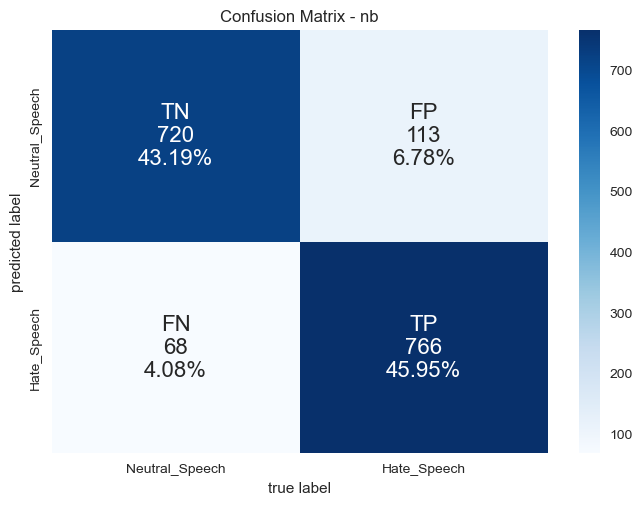

In [85]:
make_confusion_matrix(y_val, y_pr_nb_val, 'nb')

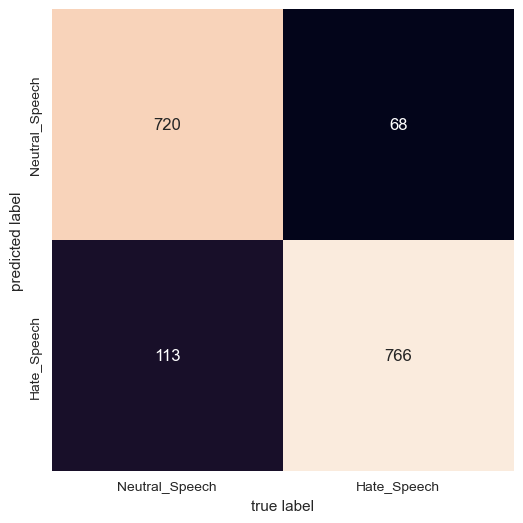

In [86]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_val, y_pr_nb_val)
sn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Neutral_Speech', 'Hate_Speech'], yticklabels=['Neutral_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

## Random Forest Classifier

In [87]:
rf = RandomForestClassifier(n_estimators=100).fit(tfidf_tr, y_tr)
y_pr_rf_tr = rf.predict(tfidf_tr)
y_pr_rf_val = rf.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_rf_tr, y_pr_rf_val, rf)

Training F1 Score:  0.9994010182689429
Testing F1 Score:  0.9132473622508793
Training Recall Score:  0.9997004194128221
Testing Recall Score:  0.934052757793765
Training Precision Score:  0.9991017964071857
Testing Precision Score:  0.893348623853211
Training Accuracy Score:  0.9994001199760048
Testing Accuracy Score:  0.9112177564487103


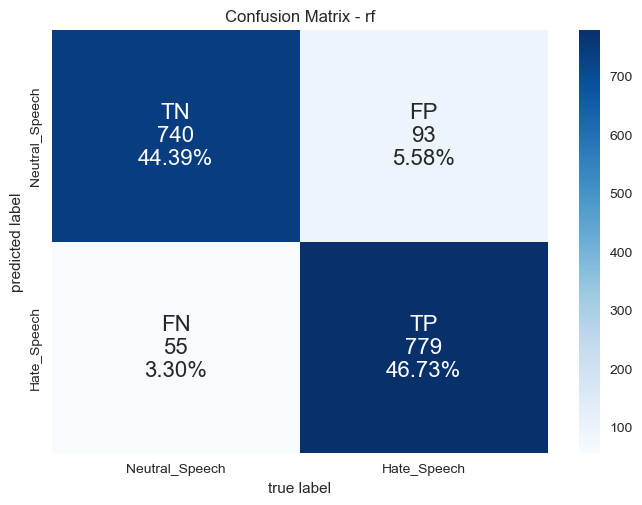

In [88]:
make_confusion_matrix(y_val,y_pr_rf_val,'rf')

## Logistic Regression

In [89]:
log = LogisticRegression().fit(tfidf_tr, y_tr)
y_pr_log_tr = log.predict(tfidf_tr)
y_pr_log_val = log.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_log_tr, y_pr_log_val, log)

Training F1 Score:  0.9637891520244461
Testing F1 Score:  0.9035087719298246
Training Recall Score:  0.944877171959257
Testing Recall Score:  0.8645083932853717
Training Precision Score:  0.9834736513875897
Testing Precision Score:  0.9461942257217848
Training Accuracy Score:  0.9644571085782844
Testing Accuracy Score:  0.907618476304739


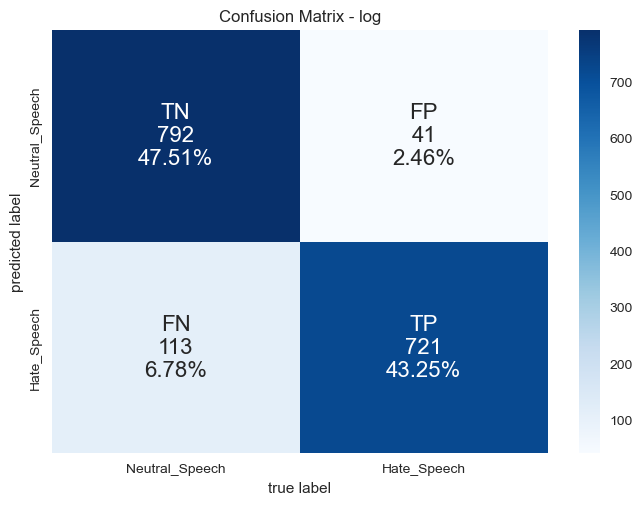

In [90]:
make_confusion_matrix(y_val, y_pr_log_val, 'log')

## Hyper-parameter tuning

In [91]:
from sklearn.model_selection import GridSearchCV

In [92]:
# Number of trees in random forrest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num =5)]

# number of features to consider at each split
max_features = ['auto', 'sqrt']

# Max number of levels in tree
max_depth = [2,4]

# min number of samples required to splid the node
min_samples_split =[2,5]

# min number of samples required at each leaf node
min_samples_leaf =[1,2]

#The function to measure the quality of a split.
#criterion = ['gini', 'entropy', 'log_loss']

In [93]:
param_grid = {'n_estimators' : n_estimators,
             'max_features' : max_features,
             'max_depth' : max_depth,
             'min_samples_split' : min_samples_split,
             'min_samples_leaf' : min_samples_leaf}
             #'criterion': criterion}
             
param_grid

{'n_estimators': [50, 87, 125, 162, 200],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [2, 4],
 'min_samples_split': [2, 5],
 'min_samples_leaf': [1, 2]}

In [94]:
rf_momdel = RandomForestClassifier()
rf_grid = GridSearchCV(estimator = rf_momdel, param_grid = param_grid, cv = 3, verbose = 3, n_jobs = 4, scoring = 'recall' )

In [95]:
import warnings

In [96]:
warnings.filterwarnings('ignore')

In [97]:
rf_grid.fit(tfidf_tr, y_tr)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [2, 4], 'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 87, 125, 162, 200]},
             scoring='recall', verbose=3)

In [98]:
rf_grid.best_params_

{'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [99]:
rf_clf_tunned = RandomForestClassifier(n_estimators = 125, max_depth = 2, max_features = 'auto', min_samples_split=2)
rf_clf_tunned.fit(tfidf_tr, y_tr)
t_rf_test_preds_lem = rf_clf_tunned.predict(tfidf_val)

[CV 2/3] END max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.616 total time=   0.1s
[CV 2/3] END max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=87;, score=0.722 total time=   0.2s
[CV 3/3] END max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=125;, score=0.683 total time=   0.3s
[CV 1/3] END max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.704 total time=   0.3s
[CV 3/3] END max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.954 total time=   0.1s
[CV 3/3] END max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=87;, score=0.708 total time=   0.2s
[CV 1/3] END max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=162;, score=0.722 total time=   0.3s
[CV 2/3] END max_depth=2, max_features=auto, min_sam

[CV 1/3] END max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.534 total time=   0.1s
[CV 1/3] END max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=125;, score=0.758 total time=   0.3s
[CV 2/3] END max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=162;, score=0.744 total time=   0.3s
[CV 3/3] END max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.742 total time=   0.4s
[CV 1/3] END max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=125;, score=0.616 total time=   0.2s
[CV 2/3] END max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=162;, score=0.765 total time=   0.3s
[CV 3/3] END max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.725 total time=   0.4s
[CV 1/3] END max_depth=2, max_features=auto, min_

In [ ]:
t_rf_precision = precision_score(y_val, t_rf_test_preds_lem)
t_rf_recall = recall_score(y_val, t_rf_test_preds_lem)
t_rf_acc_score = accuracy_score(y_val, t_rf_test_preds_lem)
t_rf_f1_score = f1_score(y_val, t_rf_test_preds_lem)
print('Random Forest with Hyper Parameters selected with GridSearch:')

print('Precision: {:.4}'.format(t_rf_precision))
print('Recall: {:.4}'.format(t_rf_recall))

print("Testing Accuracy: {:.4}".format(t_rf_acc_score))
print("F1 Score: {:.4}".format(t_rf_f1_score))

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_val, t_rf_test_preds_lem)
sn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()